# Tennis with Unity ML-Agents

---


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch.nn.functional as F
from unityagents import UnityEnvironment
import numpy as np
import torch 
from torch import nn
from collections import deque
import random
import matplotlib.pyplot as plt
import time

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux_NoVis/Tennis.x86_64")

Found path: /home/vijayah/deep-reinforcement-learning/p3_collab-compet/./Tennis_Linux_NoVis/Tennis.x86_64
Mono path[0] = '/home/vijayah/deep-reinforcement-learning/p3_collab-compet/./Tennis_Linux_NoVis/Tennis_Data/Managed'
Mono config path = '/home/vijayah/deep-reinforcement-learning/p3_collab-compet/./Tennis_Linux_NoVis/Tennis_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/vijayah/.config/unity3d/Unity Technologies/Unity Environment/Player.log


Failed to create secure directory (/run/user/1001/pulse): No such file or directory
Failed to create secure directory (/run/user/1001/pulse): No such file or directory
Failed to create secure directory (/run/user/1001/pulse): No such file or directory
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Rese

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed =100


### 2. Examine the State and Action Spaces

This environment features two agents, each controlling a racket to keep a ball in play. Each agent observes a state vector of 8 variables (positions and velocities). Agents receive +0.1 for successfully hitting the ball over the net and -0.01 for faults. The goal is to achieve an average score of 0.5 over 100 consecutive episodes to solve the environment. Each agent selects from two continuous actions: moving and jumping.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
print(f"state space{env_info.vector_observations.shape}")

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

state space(2, 24)
Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Hyper parameters


In [5]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.995            # discount factor
TAU = 1e-3              # for soft update of target parameters
LRA = 1e-4
LRC = 1e-3 # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [6]:
import copy


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.normal(size=len(x))
        self.state = x + dx
        return self.state

### Actor-Critic Network Overview

The actor-critic architecture consists of two neural networks: the **actor** and the **critic**. The actor network maps each agent's observed state to a set of actions, determining the agent's behavior. The critic network evaluates the quality of actions taken by the agents by estimating the expected reward.

In multi-agent settings, the critic receives the **concatenated states and actions from all agents** as input. This allows the critic to assess the joint behavior of all agents, which is crucial for environments where agents interact and influence each other's outcomes.

In [7]:
class Actor(nn.Module):
    def __init__(self, nS, nA): # nS: state space size, nA: action space size
        super(Actor, self).__init__()

        self.h1 = nn.Linear(nS, 128)
        self.h2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, nA)

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.tanh(self.out(x))
        return x

class Critic(nn.Module):
    def __init__(self, nS, nA): # nS: state space size, nA: action space size
        super(Critic, self).__init__()

        self.h1 = nn.Linear(nS+nA, 128)
        self.h2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

    def forward(self, s, a):
        x = torch.cat((s,a), dim=1)
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.out(x)
        return x

When finished, you can close the environment.

In [8]:
from collections import namedtuple


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state[0], action[0], reward[0], next_state[0], done[0])
        e1 = self.experience(state[1], action[1], reward[1], next_state[1], done[1])
        self.memory.append((e,e1))
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states =[]
        actions =[]
        rewards= []
        next_states = []
        dones =[]
        for i in range(2):
            states.append(torch.from_numpy(np.vstack([e[i].state for e in experiences if e is not None])).float().to(device)) 
            actions.append(torch.from_numpy(np.vstack([e[i].action for e in experiences if e is not None])).float().to(device))
            rewards.append(torch.from_numpy(np.vstack([e[i].reward for e in experiences if e is not None])).float().to(device))
            next_states.append( torch.from_numpy(np.vstack([e[i].next_state for e in experiences if e is not None])).float().to(device))
            dones.append(torch.from_numpy(np.vstack([e[i].done for e in experiences if e is not None]).astype(np.uint8)).float().to(device))
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:


class DDPGAgent:
    def __init__(self, state_size, action_size,agentidx,num_agents, update_every=UPDATE_EVERY, random_seed=0):
        self.state_size = state_size
        self.action_size = action_size
        self.random_seed = random_seed
        
        self.agent_local = Actor(state_size, action_size).to(device)
        self.agent_target = Actor(state_size, action_size).to(device)
        
        self.critic_local = Critic(state_size*num_agents, action_size*num_agents).to(device)
        self.critic_target = Critic(state_size*num_agents, action_size*num_agents).to(device)
        
        self.optimizer_actor = torch.optim.Adam(self.agent_local.parameters(), lr=LRA)
        self.optimizer_critic = torch.optim.Adam(self.critic_local.parameters(), lr=LRC)
        self.agentidx = agentidx
        #ReplayBuffer(action_size, buffer_size=int(BUFFER_SIZE), batch_size=BATCH_SIZE, seed=random_seed)
        self.t_step = 0
        self.soft_update(self.agent_local, self.agent_target, 1.0)
        self.soft_update(self.critic_local, self.critic_target, 1.0)
        self.update_every = update_every
        self.noise = OUNoise(action_size, random_seed)

    def action(self, state,noise):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.agent_local.eval()
        with torch.no_grad():
            action = self.agent_local(state).cpu().data.numpy().squeeze(0)
        self.agent_local.train()
        action += self.noise.sample()* noise  # add noise for exploration
        return np.clip(action, -1, 1)
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    

    

### MADDPG Agent and Learning Step Explained

**MADDPG (Multi-Agent Deep Deterministic Policy Gradient)** is an extension of DDPG for multi-agent environments. Each agent has its own actor and critic networks, but the critic receives the concatenated states and actions of all agents, allowing it to evaluate joint behaviors.

#### Learn Step Details

During learning:
- **Critic Loss**: For each agent, the critic estimates the Q-value for the current states and actions of all agents. The target Q-value is computed using the target critic and the next states/actions. The loss is the mean squared error between the expected and target Q-values.
- **Actor Loss**: Each agent's actor aims to maximize the expected Q-value as estimated by its critic. When calculating the actor loss, the agent's own action is computed using its actor, while other agents' actions are either computed using their actors or detached to prevent gradient flow.

#### Use of Other Agents' Actions

For each agent, the critic and actor losses depend on the actions of all agents. When updating the actor for a specific agent, the actions of other agents are detached from the computation graph. This ensures that only the current agent's actor parameters are updated, and gradients do not accidentally flow into other agents' networks.

#### Importance of Detaching

Detaching other agents' actions is crucial to avoid unintended gradient updates. Without detaching, the optimizer could modify parameters of other agents' actors during backpropagation, leading to unstable and incorrect learning. Detaching ensures that only the intended agent's actor is updated during its optimization step.

In [10]:

class MADDPG:
    def __init__(self,state_size, action_size,num_agents):
        self.memory = ReplayBuffer(action_size, buffer_size=int(BUFFER_SIZE), batch_size=BATCH_SIZE, seed=random_seed)
        self.num_agents = num_agents
        self.agents = [DDPGAgent(action_size=2,state_size=24,update_every=4, agentidx=idx,num_agents= num_agents) for idx in range(num_agents)]
       
        self.t_step =0
    
    def actions(self,states,noise_scale):
         actions =[]
         for idx,agent in enumerate(self.agents):
            actions.append(agent.action(state=states[idx],noise=noise_scale))
         return actions
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.memory.add(state,action,reward,next_state,done)
        
        if len(self.memory) > 1e3:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
    
    def learn(self, experiences, gamma):
        #critic update
        states, actions, rewards, next_states, dones = experiences
        nextActions = []
        with torch.no_grad():
            for idx,agent in enumerate(self.agents): 
                nextActions.append(agent.agent_target(next_states[idx]))
            nextactions_cat = torch.cat(nextActions,dim=1)
        states_cat = torch.cat(states,dim=1)
        next_states_cat = torch.cat(next_states,dim=1)
        actions_cat = torch.cat(actions,dim=1)

        
        for idx,agent in enumerate(self.agents): 
            Q_expected = agent.critic_local(states_cat,actions_cat)
            with torch.no_grad():
                Q_target_next = agent.critic_target(next_states_cat,nextactions_cat)
            Q_target = rewards[agent.agentidx]+ gamma * Q_target_next * (1 - dones[agent.agentidx])
            loss = F.mse_loss(Q_expected, Q_target)
            agent.optimizer_critic.zero_grad()  
            loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.critic_local.parameters(), 1.0)
            agent.optimizer_critic.step()      

        for idx,agent in enumerate(self.agents): 
            for p in agent.critic_local.parameters():
                p.requires_grad = False
            actions_pred =[]
            for jdx,agt in enumerate(self.agents): 
                if jdx ==idx:
                    actions_pred.append(agt.agent_local(states[jdx]))
                else:
                    actions_pred.append(agt.agent_local(states[jdx]).detach())
                    #actions_pred.append(actions[idx].detach())
            actions_pred_cat = torch.cat(actions_pred,dim=1)
            action_loss = -agent.critic_local(states_cat,actions_pred_cat).mean()
            agent.optimizer_actor.zero_grad()
            action_loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.agent_local.parameters(), 1.0)
            agent.optimizer_actor.step()
            for p in agent.critic_local.parameters():
                p.requires_grad = True
            
        self.soft_update()

    def soft_update(self):
         for idx,agent in enumerate(self.agents):
            agent.soft_update(agent.critic_local, agent.critic_target, TAU)
            agent.soft_update(agent.agent_local, agent.agent_target, TAU)


Episode: 1	 Score: 0.0	 Avg. Reward: 0.0	 Avg. Reward A: 0.0	 Avg. Reward B: -0.009999999776482582
Episode: 2	 Score: 0.0	 Avg. Reward: 0.0	 Avg. Reward A: 0.0	 Avg. Reward B: -0.014999999664723873
Episode: 3	 Score: 0.0	 Avg. Reward: 0.0	 Avg. Reward A: 0.0	 Avg. Reward B: -0.019999999552965164
Episode: 4	 Score: 0.0	 Avg. Reward: 0.0	 Avg. Reward A: 0.0	 Avg. Reward B: -0.024999999441206455
Episode: 5	 Score: 0.0	 Avg. Reward: 0.0	 Avg. Reward A: 0.0	 Avg. Reward B: -0.029999999329447746
Episode: 6	 Score: 0.0	 Avg. Reward: 0.0	 Avg. Reward A: -0.0016666666294137638	 Avg. Reward B: -0.033333332588275276
Episode: 3	 Score: 0.0	 Avg. Reward: 0.0	 Avg. Reward A: 0.0	 Avg. Reward B: -0.019999999552965164
Episode: 4	 Score: 0.0	 Avg. Reward: 0.0	 Avg. Reward A: 0.0	 Avg. Reward B: -0.024999999441206455
Episode: 5	 Score: 0.0	 Avg. Reward: 0.0	 Avg. Reward A: 0.0	 Avg. Reward B: -0.029999999329447746
Episode: 6	 Score: 0.0	 Avg. Reward: 0.0	 Avg. Reward A: -0.0016666666294137638	 Avg. Rewa

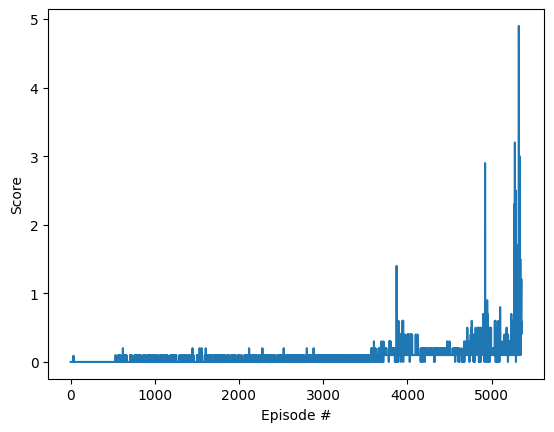

In [11]:


maagent = MADDPG(action_size=2,state_size=24,num_agents=2)
def maddpg(n_episodes=100000, max_t=200, print_every=100):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores                  # initialize epsilon
    noise_scale=0.2
    noise_decay=0.999
    score_a =0
    score_b =0
    scores_window_a = deque(maxlen=100)
    scores_window_b = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        states = env.reset(train_mode=True)[brain_name].vector_observations
        score = 0
        while True:
            actions = maagent.actions(states,noise_scale)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done
            maagent.step(states,actions,rewards,next_states,dones)
            states = next_states
            score += np.max(rewards)
            score_a += rewards[0]
            score_b += rewards[1]
            noise_scale *= noise_decay
            if np.any(dones):
                break
        scores_window.append(score)
        scores_window_a.append(score_a)
        scores_window_b.append(score_b) # save most recent score
        scores.append(score)              # save most recent score
        average_reward = sum(scores_window)/len(scores_window)
        average_reward_a = sum(scores_window_a)/len(scores_window_a)
        average_reward_b = sum(scores_window_b)/len(scores_window_b)
        #eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('Episode: {}\t Score: {}\t Avg. Reward: {}\t Avg. Reward A: {}\t Avg. Reward B: {}'.format(i_episode, score, average_reward,average_reward_a,average_reward_b))
        if average_reward >= 0.5:
            for idx, agent in enumerate(maagent.agents):
                file = f"checkpoints/agent_{idx}_checkpoint.pth"
                torch.save(agent.agent_target.state_dict(), file)
            print("\t--> SOLVED! <--\t")
            break

    return scores

scores = maddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```